# GeekBrains
## Машинное обучение в бизнесе
## ДЗ Урока 2 ( Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)
## Виталий Казанцев

### Домашнее задание
  
1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vitaly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_38886/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 25.7 s, sys: 491 ms, total: 26.1 s
Wall time: 26.1 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 56s, sys: 87.7 ms, total: 2min 56s
Wall time: 2min 56s


In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [13]:
common_dictionary[10]

'ватутин'

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 25.4 s, sys: 28 ms, total: 25.4 s
Wall time: 25.4 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(20, 0.9745538)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: научный nn конкурс фильм канал палата живой
topic_1: рост цена рубль гражданин банк тыс рынок
topic_2: млрд американский сша ставка миссия эксперт санкция
topic_3: наука программа россия развитие участник фестиваль экономический
topic_4: китай китайский налог препарат японский остров япония
topic_5: университет проверка ресторан брюссель грунт стресс таможенный
topic_6: знаменитый ск собственность выпуск пост ухо лесной
topic_7: восток индия годовой разместить грант округ сближение
topic_8: франция звезда французский париж устанавливать проявляться умереть
topic_9: вода студент лёд рассказывать еда берег вход
topic_10: всё исследование день большой жизнь очень газета
topic_11: млн северный млрд сша американский рейтинг место
topic_12: украина ракета украинский запуск пенсия запустить киев
topic_13: ребёнок фонд статья рубль область лицо nn
topic_14: помощь агентство население министерство данные россия развитие
topic_15: район земля источник доллар задержать эксперимент чиновн

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.109439,0.0,0.000000,0.0,0.118782,0.00000,...,0.0,0.0,0.0,0.629946,0.000000,0.115454,0.0,0.0,0.018806,0.000000
1,4896,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.276435,0.663031,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.974554,0.0,0.0,0.000000,0.000000
3,4898,0.0,0.0,0.0,0.000000,0.0,0.082064,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.431069,0.0,0.0,0.000000,0.019646
4,4899,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.28735,...,0.0,0.0,0.0,0.284596,0.000000,0.047906,0.0,0.0,0.000000,0.000000


In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.12444696, 0.        , 0.        , 0.        ,
       0.10198863, 0.        , 0.01873249, 0.16194074, 0.        ,
       0.21233375, 0.        , 0.        , 0.18834709, 0.        ,
       0.        , 0.        , 0.        , 0.15227711, 0.        ,
       0.02839365, 0.        , 0.        , 0.        , 0.        ])

In [23]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.042535,0.037071,0.100201,0.021763,0.000000,0.049261,0.000000,0.003122,0.03407,...,0.012886,0.0,0.057663,0.206495,0.136145,0.004732,0.023734,0.00000,0.006568,0.000000
1,u108690,0.021753,0.062605,0.049853,0.018554,0.002084,0.006528,0.007671,0.006274,0.00000,...,0.055642,0.0,0.038493,0.090163,0.048553,0.013522,0.053059,0.00224,0.117425,0.000000
2,u108339,0.042175,0.040576,0.047104,0.027899,0.000000,0.000000,0.010560,0.002951,0.00000,...,0.043247,0.0,0.138766,0.158463,0.058150,0.063687,0.025291,0.02029,0.059399,0.003662


In [25]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [26]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.042535,0.037071,0.100201,0.021763,0.000000,0.049261,0.000000,0.003122,0.03407,...,0.0,0.057663,0.206495,0.136145,0.004732,0.023734,0.00000,0.006568,0.000000,0
1,u108690,0.021753,0.062605,0.049853,0.018554,0.002084,0.006528,0.007671,0.006274,0.00000,...,0.0,0.038493,0.090163,0.048553,0.013522,0.053059,0.00224,0.117425,0.000000,1
2,u108339,0.042175,0.040576,0.047104,0.027899,0.000000,0.000000,0.010560,0.002951,0.00000,...,0.0,0.138766,0.158463,0.058150,0.063687,0.025291,0.02029,0.059399,0.003662,1


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [29]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04051886, 0.04068704, 0.31224519, 0.27774208, 0.06218977,
       0.01841169, 0.0954774 , 0.13986818, 0.02507156, 0.05475477])

In [31]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.240580, F-Score=0.710, Precision=0.621, Recall=0.829


In [33]:
import itertools

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1631  124]
 [  43  202]]


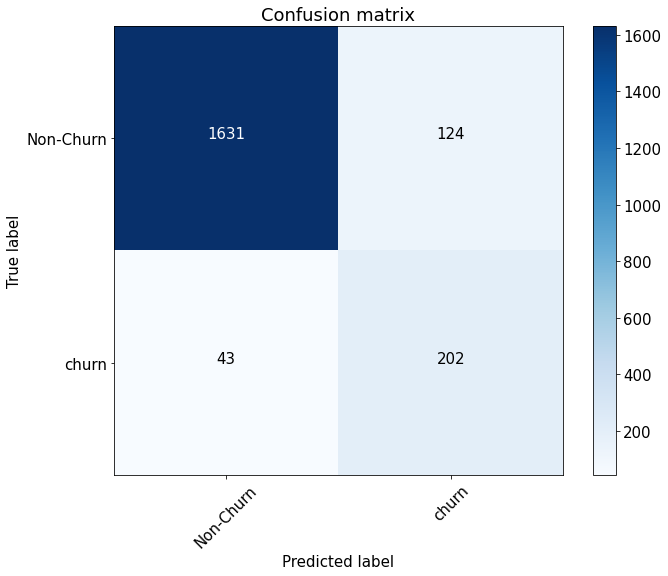

In [35]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [36]:
roc_auc_score(y_test, preds)

0.9531554160125589

In [37]:
metrics_df = pd.DataFrame({'roc_auc': [roc_auc_score(y_test, preds)], 'presicion': [precision[ix]], 
                                       'recall': [recall[ix]], 'fscore': [fscore[ix]]})
metrics_df

,roc_auc,presicion,recall,fscore
0,0.953155,0.620795,0.828571,0.70979


___2.___  
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [38]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [39]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.03609632, 0.03679396, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04530713, 0.        , 0.        , 0.        , 0.        ,
       0.00630039, 0.        , 0.04497111, 0.30138959, 0.        ,
       0.        , 0.        , 0.        , 0.19933958, 0.        ])

In [40]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.022259,0.070438,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.030060,0.206950,0.024272,0.00000,0.000000,0.0,0.000000,0.0
1,u108690,0.010982,0.015886,0.034732,0.009216,0.0,0.0,0.0,0.0,0.0,...,0.054626,0.0,0.017317,0.016819,0.049200,0.00000,0.032599,0.0,0.037831,0.0
2,u108339,0.020336,0.039324,0.015701,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.036951,0.0,0.150464,0.157547,0.029018,0.05884,0.028676,0.0,0.000000,0.0


In [41]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.022259,0.070438,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.030060,0.206950,0.024272,0.00000,0.000000,0.0,0.000000,0.0,0
1,u108690,0.010982,0.015886,0.034732,0.009216,0.0,0.0,0.0,0.0,0.0,...,0.0,0.017317,0.016819,0.049200,0.00000,0.032599,0.0,0.037831,0.0,1
2,u108339,0.020336,0.039324,0.015701,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.150464,0.157547,0.029018,0.05884,0.028676,0.0,0.000000,0.0,1


In [42]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [43]:
logreg_median = LogisticRegression()
#обучим 
logreg_median.fit(X_train, y_train)

LogisticRegression()

In [44]:
preds = logreg_median.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05302653, 0.03284597, 0.38302596, 0.42112372, 0.0212973 ,
       0.02598125, 0.08899615, 0.10476847, 0.02992844, 0.1153144 ])

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.330366, F-Score=0.769, Precision=0.801, Recall=0.739


Confusion matrix, without normalization
[[1710   45]
 [  65  180]]


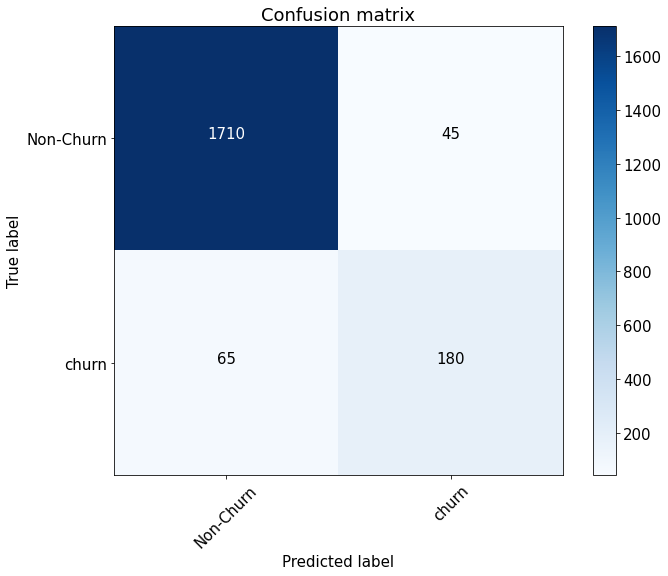

In [46]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
roc_auc_score(y_test, preds)

0.9713890342461771

In [48]:
metrics_df

,roc_auc,presicion,recall,fscore
0,0.953155,0.620795,0.828571,0.70979


In [49]:
metrics = {'roc_auc':roc_auc_score(y_test, preds), 'presicion': precision[ix], 'recall': recall[ix], 'fscore': fscore[ix]}
metrics_df = metrics_df.append(metrics, ignore_index=True)
metrics_df

,roc_auc,presicion,recall,fscore
0,0.953155,0.620795,0.828571,0.709790
1,0.971389,0.800885,0.738776,0.768577


__3___  
Повторить п.2, но используя уже не медиану, а max

In [50]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [51]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.35971442, 0.13731033, 0.07209236, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01159563,
       0.14400078, 0.02578316, 0.08458281, 0.29066348, 0.08227731,
       0.18779086, 0.        , 0.12445985, 0.48750204, 0.16531764,
       0.05101884, 0.12775655, 0.        , 0.47837287, 0.        ])

In [52]:
user_embeddings_max= pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.147643,0.124447,0.304597,0.117320,0.000000,0.193579,0.000000,0.018732,0.161941,...,0.077318,0.0,0.182198,0.384992,0.623567,0.028394,0.077773,0.000000,0.039411,0.00000
1,u108690,0.064275,0.188200,0.152676,0.070977,0.012504,0.027746,0.046028,0.037643,0.000000,...,0.152814,0.0,0.129253,0.306631,0.105755,0.055996,0.154000,0.013440,0.409834,0.00000
2,u108339,0.156777,0.088262,0.134258,0.147858,0.000000,0.000000,0.037996,0.017706,0.000000,...,0.122181,0.0,0.297589,0.271784,0.184810,0.095699,0.057066,0.082604,0.330654,0.02197


In [53]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.147643,0.124447,0.304597,0.117320,0.000000,0.193579,0.000000,0.018732,0.161941,...,0.0,0.182198,0.384992,0.623567,0.028394,0.077773,0.000000,0.039411,0.00000,0
1,u108690,0.064275,0.188200,0.152676,0.070977,0.012504,0.027746,0.046028,0.037643,0.000000,...,0.0,0.129253,0.306631,0.105755,0.055996,0.154000,0.013440,0.409834,0.00000,1
2,u108339,0.156777,0.088262,0.134258,0.147858,0.000000,0.000000,0.037996,0.017706,0.000000,...,0.0,0.297589,0.271784,0.184810,0.095699,0.057066,0.082604,0.330654,0.02197,1


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [55]:
logreg_max = LogisticRegression()
#обучим 
logreg_max.fit(X_train, y_train)

LogisticRegression()

In [56]:
preds = logreg_max.predict_proba(X_test)[:, 1]
preds[:10]

array([3.31723504e-02, 2.42247257e-04, 7.63136157e-01, 4.42807764e-01,
       1.25619171e-02, 3.35523602e-03, 4.99445339e-02, 1.41664615e-01,
       1.59833576e-02, 3.46073408e-03])

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373362, F-Score=0.836, Precision=0.840, Recall=0.833


Confusion matrix, without normalization
[[1716   39]
 [  42  203]]


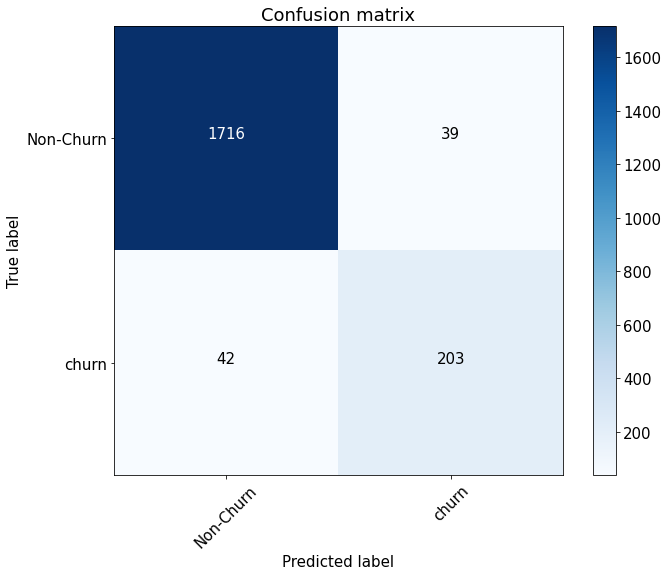

In [58]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [59]:
roc_auc_score(y_test, preds)

0.9823036223036223

In [60]:
metrics = {'roc_auc':roc_auc_score(y_test, preds), 'presicion': precision[ix], 'recall': recall[ix], 'fscore': fscore[ix]}
metrics_df = metrics_df.append(metrics, ignore_index=True)
metrics_df

,roc_auc,presicion,recall,fscore
0,0.953155,0.620795,0.828571,0.709790
1,0.971389,0.800885,0.738776,0.768577
2,0.982304,0.839506,0.832653,0.836066


In [61]:
metrics_df.index = ['mean', 'median', 'max']
metrics_df

,roc_auc,presicion,recall,fscore
mean,0.953155,0.620795,0.828571,0.709790
median,0.971389,0.800885,0.738776,0.768577
max,0.982304,0.839506,0.832653,0.836066


__ВЫВОДЫ:__  max дает лучшие результаты, возможно потому что минимизирует разброс в увлечениях пользователя что позволяет выявить максимально интересные темы. 